In [1]:
import keras
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten, Dropout, Add, Activation, Input, BatchNormalization, ZeroPadding2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
#import data
import h5py
import numpy as np

train_set = h5py.File('train_signs.h5', 'r')
train_x = np.array(train_set['train_set_x'][:])
train_y = np.array(train_set['train_set_y'][:])
classes = np.array(train_set['list_classes'].shape[0])

test_set = h5py.File('test_signs.h5', 'r')
test_x = np.array(test_set['test_set_x'][:])
test_y = np.array(test_set['test_set_y'][:])

The label of this picture is 5
There are 6 classes


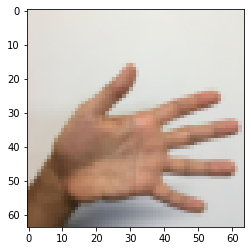

In [3]:
#show our data
plt.imshow(train_x[0])
print('The label of this picture is', train_y[0])
print('There are', classes, 'classes')

In [4]:
#data preprocessing
x_train = train_x / 255
x_test = test_x / 255

y_train = np_utils.to_categorical(train_y)
y_test = np_utils.to_categorical(test_y)

print('trainset has', x_train.shape[0], 'pictures')
print('dataset has', x_test.shape[0], 'pictures')
print('the shape of train data is', x_train.shape)
print('the shape of test data is', x_test.shape)

trainset has 1080 pictures
dataset has 120 pictures
the shape of train data is (1080, 64, 64, 3)
the shape of test data is (120, 64, 64, 3)


In [5]:
def identity_block(x, f):
    
    x_shortcut = x
    
    #convolution path
    x = Conv2D(filters = f, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = f, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    #add
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [6]:
def convolutional_block(x, f):
    
    x_shortcut = x
    
    #convolution path
    x = Conv2D(filters = f, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters = f, kernel_size = (3, 3), strides = (1, 1), padding = 'same')(x)
    x = BatchNormalization(axis = 3)(x)
    x = Activation('relu')(x)
    
    #identity path
    x_shortcut = Conv2D(filters = f, kernel_size = (3, 3), strides = (2, 2), padding = 'same')(x_shortcut)
    x_shortcut = BatchNormalization(axis = 3)(x_shortcut)
    
    #add
    x = Add()([x, x_shortcut])
    x = Activation('relu')(x)
    
    return x

In [7]:
x_input = Input(shape = (64, 64, 3))

x = ZeroPadding2D((3, 3))(x_input)

x = Conv2D(64, (7, 7), strides = (2, 2))(x)
x = BatchNormalization(axis = 3)(x)
x = Activation('relu')(x)
x = MaxPooling2D((3, 3), strides = (2, 2))(x)

x = identity_block(x, 64)
x = identity_block(x, 64)
x = identity_block(x, 64)

x = convolutional_block(x, 128)
x = identity_block(x, 128)
x = identity_block(x, 128)
x = identity_block(x, 128)

x = convolutional_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)
x = identity_block(x, 256)

x = convolutional_block(x, 512)
x = identity_block(x, 512)
x = identity_block(x, 512)

x = AveragePooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(classes, activation = 'softmax')(x)

model = Model(inputs = x_input, outputs = x)

model.summary()














__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d_1[0][0]                   
________________________________________________________________________________________________

In [8]:
import time
from keras.callbacks import ModelCheckpoint

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("resnet34B.h5", monitor='val_acc', verbose=1, mode='max', save_best_only=True)

start = time.time()
history = model.fit(x_train, y_train, validation_split=0.15, epochs=100, batch_size=32, callbacks=[checkpoint])
end = time.time()

print("Total time: ", end - start)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 918 samples, validate on 162 samples
Epoch 1/100
918/918 [==============================] - 37s 41ms/step - loss: 1.0872 - acc: 0.6492 - val_loss: 14.0287 - val_acc: 0.1296

Epoch 00001: val_acc improved from -inf to 0.12963, saving model to resnet34B.h5
Epoch 2/100
918/918 [==============================] - 20s 21ms/step - loss: 0.4438 - acc: 0.8410 - val_loss: 14.0287 - val_acc: 0.1296

Epoch 00002: val_acc did not improve from 0.12963
Epoch 3/100
918/918 [==============================] - 19s 21ms/step - loss: 0.3160 - acc: 0.9041 - val_loss: 14.0287 - val_acc: 0.1296

Epoch 00003: val_acc did not improve from 0.12963
Epoch 4/100
918/918 [==============================] - 19s 21ms/step - loss: 0.2432 - acc: 0.9129 - val_loss: 14.0287 - val_acc: 0.1296

Epoch 00004: val_acc did not improve from 0.12963
Epoch 5/100
918/918 [==============================] - 20s 21ms/step - loss: 

918/918 [==============================] - 19s 21ms/step - loss: 0.1242 - acc: 0.9608 - val_loss: 14.0287 - val_acc: 0.1296

Epoch 00037: val_acc did not improve from 0.95679
Epoch 38/100
918/918 [==============================] - 19s 21ms/step - loss: 0.0587 - acc: 0.9749 - val_loss: 10.8379 - val_acc: 0.1420

Epoch 00038: val_acc did not improve from 0.95679
Epoch 39/100
918/918 [==============================] - 19s 21ms/step - loss: 0.0551 - acc: 0.9804 - val_loss: 7.8542 - val_acc: 0.3148

Epoch 00039: val_acc did not improve from 0.95679
Epoch 40/100
918/918 [==============================] - 19s 21ms/step - loss: 0.0373 - acc: 0.9891 - val_loss: 7.9510 - val_acc: 0.4012

Epoch 00040: val_acc did not improve from 0.95679
Epoch 41/100
918/918 [==============================] - 19s 21ms/step - loss: 0.0207 - acc: 0.9902 - val_loss: 3.7401 - val_acc: 0.5802

Epoch 00041: val_acc did not improve from 0.95679
Epoch 42/100
918/918 [==============================] - 19s 21ms/step - loss


Epoch 00079: val_acc did not improve from 0.98765
Epoch 80/100
918/918 [==============================] - 19s 21ms/step - loss: 6.4097e-05 - acc: 1.0000 - val_loss: 0.0898 - val_acc: 0.9691

Epoch 00080: val_acc did not improve from 0.98765
Epoch 81/100
918/918 [==============================] - 19s 21ms/step - loss: 4.0925e-05 - acc: 1.0000 - val_loss: 0.0899 - val_acc: 0.9691

Epoch 00081: val_acc did not improve from 0.98765
Epoch 82/100
918/918 [==============================] - 19s 21ms/step - loss: 4.5148e-05 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9691

Epoch 00082: val_acc did not improve from 0.98765
Epoch 83/100
918/918 [==============================] - 19s 21ms/step - loss: 3.6467e-05 - acc: 1.0000 - val_loss: 0.0895 - val_acc: 0.9630

Epoch 00083: val_acc did not improve from 0.98765
Epoch 84/100
918/918 [==============================] - 19s 21ms/step - loss: 8.2881e-05 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9691

Epoch 00084: val_acc did not improve from 0.

In [9]:
model = keras.models.load_model("resnet34B.h5")
pred = model.evaluate(x_test, y_test)
print('loss is', pred[0])
print('accuracy is', pred[1])

120/120 [==============================] - 2s 20ms/step
loss is 0.134948326733623
accuracy is 0.9666666666666667


In [10]:
np.save('r34B_loss.npy', history.history['loss'])
np.save('r34B_acc.npy', history.history['acc'])
np.save('r34B_vloss.npy', history.history['val_loss'])
np.save('r34B_vacc.npy', history.history['val_acc'])